In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uniprot
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [8]:
seqids, fastas = uniprot.read_fasta('/Users/daniel/desktop/cp341/uniprot_sprot.fasta')

In [3]:
len(seqids)

568002

In [3]:
species = set()
for seqid in seqids:
    temp = [x for x, j in enumerate(fastas[seqid]['description'].split()) if j[0:3] == "OS="][0]
    #print(temp)
    try:
        #print()
        #print(temp)
        first_part = fastas[seqid]['description'].split()[temp]
        if fastas[seqid]['description'].split()[temp+1][0:3] != "OX=":
            first_part += " " + fastas[seqid]['description'].split()[temp+1][0:3]
        species.add(first_part)
    except IndexError:
        print(fastas[seqid])
        print(temp)
        break

species

{'OS=Danio aff',
 'OS=Ostreococcus tau',
 'OS=Splachnum sph',
 'OS=Oncorhynchus gor',
 'OS=Panchlora vir',
 'OS=Archimandrita tes',
 'OS=Haemonchus con',
 'OS=Phyllomedusa pal',
 'OS=Phaseolus coc',
 'OS=Micranthus jun',
 'OS=Streptomyces rim',
 'OS=Avibacterium par',
 'OS=Dendrothele bis',
 'OS=Drosophila ame',
 'OS=Lampronycteris bra',
 'OS=Oenothera ber',
 'OS=Myxococcus ful',
 'OS=Proechimys sim',
 'OS=Magnaporthiopsis poa',
 'OS=Penicillium cam',
 'OS=Mesomycoplasma con',
 'OS=Xanthomonas axo',
 'OS=Connochaetes tau',
 'OS=Campylobacter ups',
 'OS=Nicandra phy',
 'OS=Hydrangea que',
 'OS=Synechococcus sp.',
 'OS=Cucumber nec',
 'OS=Microtus lon',
 'OS=Pleurastrum ter',
 'OS=Centruroides bae',
 'OS=Pione vas',
 'OS=Drosera bur',
 'OS=Clostridium sar',
 'OS=Micranthes pun',
 'OS=Lama vic',
 'OS=Fervidobacterium pen',
 'OS=Berberis wil',
 'OS=Bunyavirus La',
 'OS=Acer pal',
 'OS=Picea pun',
 'OS=Hepatitis GB',
 'OS=Sputnik vir',
 'OS=Centruroides scu',
 'OS=Morella cer',
 'OS=Strepto

In [5]:
np.array(species)[np.array(species) == "OS=Homo sapiens"]

array([], dtype=object)

In [33]:
fastas['sp|P09430']['description']
temp = [x for x, j in enumerate(fastas['sp|P09430']['description'].split()) if j[0:3] == "OS="][0]
print(temp)
fastas['sp|P09430']['description'].split()[temp]
fastas['sp|P09430']['description'].split()[temp+1]
fastas['sp|P09430']['description'].split()[temp+2]

7


'OX=9606'

In [25]:
[x for x in fastas['sp|P09430']['description'].split() if x[0:2] == "OS="]

['OS=Homo']

In [6]:
fastas['sp|P09430']['description']

'sp|P09430 STP1_HUMAN Spermatid nuclear transition protein 1 OS=Homo sapiens OX=9606 GN=TNP1 PE=1 SV=2'

In [6]:
analysis = ProteinAnalysis(fastas[seqids[0]]['sequence'])

In [8]:
analysis.molecular_weight()

29735.10070000003

In [9]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

Using cache found in /Users/daniel/.cache/torch/hub/facebookresearch_esm_main


In [11]:
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
    ("blah", fastas['sp|P21060']['sequence'])
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [13]:
sequence_representations[-1]

tensor([ 0.0784,  0.2098, -0.0633,  ..., -0.0135,  0.1095,  0.3748])

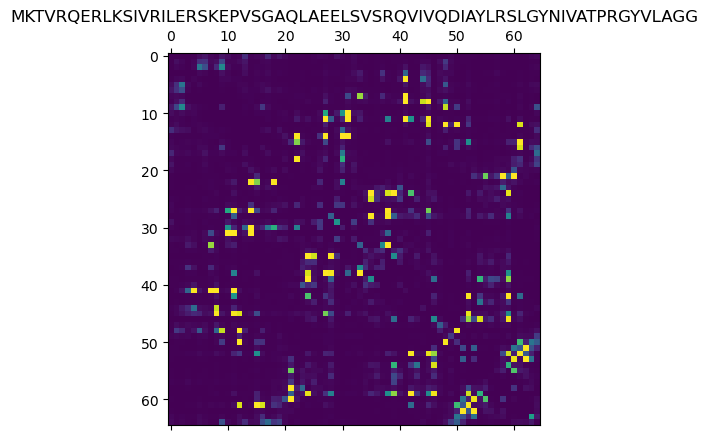

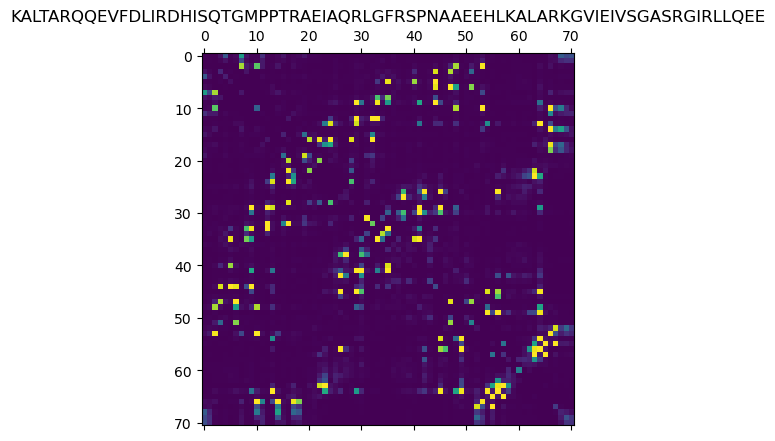

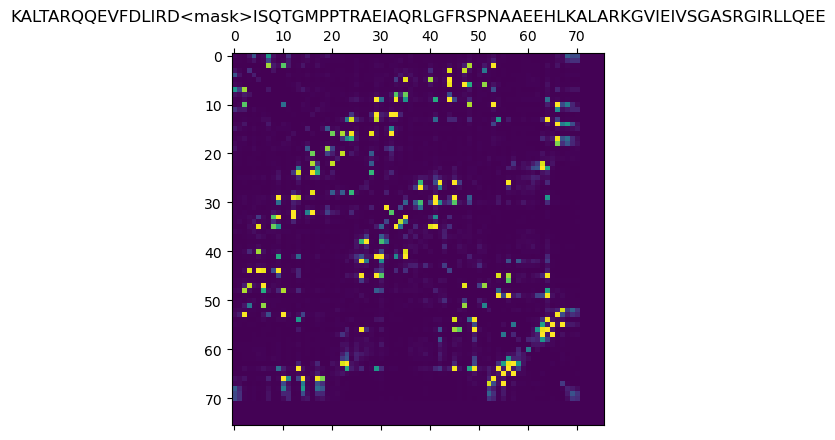

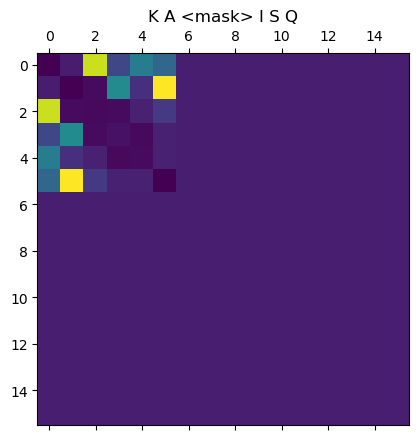

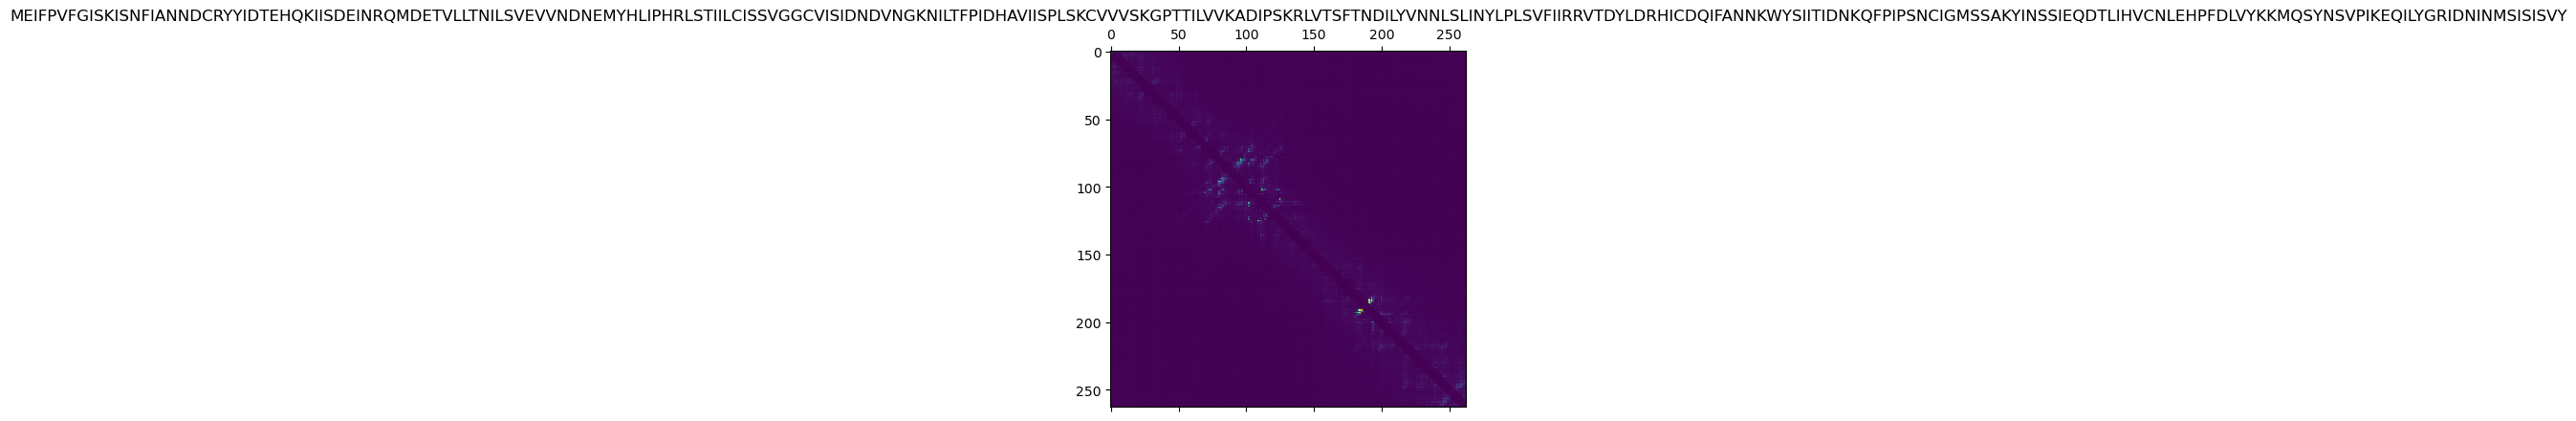

In [12]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

In [13]:
sequence_representations[3].shape

torch.Size([1280])

In [17]:
token_representations[3].shape

torch.Size([73, 1280])